In [1]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 4.3 MB/s eta 0:00:0000:01
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


False

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [4]:
import data
train_df, test_df = data.get_data()

In [5]:
train_df.head()

,sentence,label
0,usairways did i mention im a silver preferred ...,1
1,that will be the third time i have been called...,1
2,its taken care of already ive come to expect t...,1
3,flight 1219 my frustration boiled over after d...,1
4,worst customer service ever you cancelled flig...,1


In [9]:
train_sentences = train_df.sentence.values.tolist()
train_labels = train_df.label.values.tolist()

test_sentences = test_df.sentence.values.tolist()
test_labels = test_df.label.values.tolist()

In [31]:
len(train_sentences)

14596

In [7]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata

In [8]:
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [11]:
%%time

norm_train_sentences = pre_process_corpus(train_sentences)
norm_test_sentences = pre_process_corpus(test_sentences)

100%|██████████| 200/200 [00:00<00:00, 5801.61it/s]

CPU times: user 2.03 s, sys: 287 ms, total: 2.32 s
Wall time: 3.31 s


In [32]:
type(norm_train_sentences)

list

In [12]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_sentences)
t.word_index['<PAD>'] = 0

In [13]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('9may5sep', 16489), ('<PAD>', 0), 1)

In [14]:
train_sequences = t.texts_to_sequences(norm_train_sentences)
test_sequences = t.texts_to_sequences(norm_test_sentences)

In [15]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=16490
Number of Documents=14596


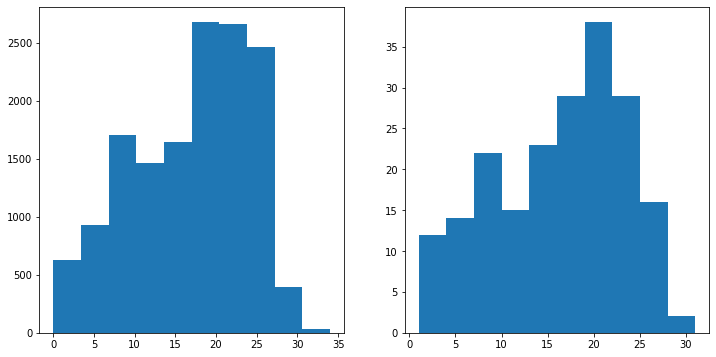

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

##### Sequence Normalization

##### Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length. For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [17]:
MAX_SEQUENCE_LENGTH = 1000

In [18]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((14596, 1000), (200, 1000))

In [19]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [21]:
y_train = le.fit_transform(train_labels)
y_test = le.transform(test_labels)

In [22]:
VOCAB_SIZE = len(t.word_index)

In [23]:
EMBED_SIZE = 300
EPOCHS=2
BATCH_SIZE=128

In [24]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         4947000   
                                                                 
 conv1d (Conv1D)             (None, 1000, 128)         153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 128)         0         
 )                                                               
                                                                 


2022-07-06 14:00:36.476045: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 conv1d_1 (Conv1D)           (None, 500, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 250, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 32)           8224      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 125, 32)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 4000)              0         
                                                                 
 dense (Dense)               (None, 256)               1024256   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
          

In [25]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/2
103/103 [==============================] - 168s 2s/step - loss: 0.4701 - accuracy: 0.7813 - val_loss: 0.7682 - val_accuracy: 0.6712
Epoch 2/2
103/103 [==============================] - 145s 1s/step - loss: 0.2567 - accuracy: 0.8925 - val_loss: 0.5347 - val_accuracy: 0.7822


In [26]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/2
103/103 [==============================] - 144s 1s/step - loss: 0.1484 - accuracy: 0.9422 - val_loss: 0.5710 - val_accuracy: 0.7986
Epoch 2/2
103/103 [==============================] - 144s 1s/step - loss: 0.0757 - accuracy: 0.9722 - val_loss: 1.0258 - val_accuracy: 0.7164


In [30]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

7/7 [==============================] - 1s 97ms/step - loss: 0.6883 - accuracy: 0.7850
Accuracy: 78.50%


In [29]:
predictions = model.predict_classes(X_test).ravel()
predictions[:10]

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)